# Quantum Fourier transform and its applications: Part 2

Suppose $f$ is a periodic function producing a single bit as output and such that $f(x + r)=f(x)$, for some unknown $0 <r<2^L$, where $x,r \in \{ 0,1,2,\ldots \}$. Given an oracle $U$ which performs the unitary transform $U|x\rangle|y\rangle \to |x\rangle|y \oplus f(x)\rangle$ (where $\oplus$ denotes addition modulo $2^n$ where $n$ is size of that register) how many oracles and other operations are required to determine $r$? Note that in practice $U$ operates on a ﬁnite domain, whose size is determined by the desired accuracy for $r$. We will follow a quantum algorithm which solves this problem using one oracle, and $O(L^2)$ other operations. This problem involves finding the period of the function, thus called **period finding**.

In [1]:
!pip3 install tabulate
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from tabulate import tabulate
import numpy as np
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

You should consider upgrading via the '/usr/local/opt/python/bin/python3.7 -m pip install --upgrade pip' command.


In [18]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

def __c_amod15(power):
    """Controlled multiplication by 7 mod 15"""
    U = QuantumCircuit(4)        
    for iteration in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = "7^%i mod 15" % (power)
    print(U.name)
    c_U = U.control()
    return c_U


(Note: Here $\hat{x}$ is used for fourier transfrom and $\tilde{x}$ is used for a good approximation of $x$)
Here are the steps of the algorithm:

1. We initialize the state to $|0\rangle|0\rangle$. Notice that the first one is a reigster with $t$ quibts all initialized to $|0\rangle$.

2. Then we create a superposition:
 $$\to \frac{1}{2^t} \sum^{2^t-1}_{x=0} |x\rangle|0\rangle$$

 

In [19]:
t=3
qc = QuantumCircuit(t+4,t)
for i in range(t):
    qc.h(i)      # The first t qubits are the first register (storing 'x')
qc.x(6) #The second register is in state |1>

3. We will now also make this into the state $\frac{1}{2^t} \sum^{2^t-1}_{x=0} |x\rangle|1\rangle$ since our oracle does multiplication instead of addition. Note that this is the same thing since all we need is the state. After we apply $O$ which is the multiplying oracle, we get,
$$\to \frac{1}{2^t} \sum_{x=0}^{2^t-1} |x\rangle|f(x)\rangle \approx \frac{1}{\sqrt{r 2^t}} \sum_{l=0}^{r-1} \sum_{x=0}^{2^t-1} e^{2 \pi i l x/r} |x\rangle |\hat{f}(l)\rangle$$  

Here we are taking $f(x) = 7^x \text{ mod } 15$. Looking closely at it, it will reveal that it is designed to give a period of $4$. We will verify it. So the Oracle function is given below. Notice that even though we can take many other functions but finding the Oracle can be extremely difficult.

In [20]:
# Oracle for the f(x) mentioned above
def Oracle(qc):
    for q in range(3):
        qc.append(__c_amod15(2**q), [q] + [i+3 for i in range(4)])

Oracle(qc)

7^1 mod 15
7^2 mod 15
7^4 mod 15


4. Now, by applying the inverse Fourier transform to the first register, we get:
$$\to \frac{1}{\sqrt{r}} \sum_{l=0}^{r-1} |\widetilde{l/r}\rangle|\hat{f}(l)\rangle$$

5. Then, measure the first register:
$$ \to \widetilde{l/r}$$

Now this has some abuse of notation happening here. So first off, the actual state would not be $\widetilde{l/r}$ but rather would be $\widetilde{l/r}*(2^t)\mod(2^t)$ as the state stored in that register so on measurement you would have to analyze the results keeping this in mind. Using the results keeping this in mind, you can analyze the fractions of their phases of the eigen values of the oracle (the logic of phase estimation) and that would be $(\widetilde{l/r}*(2^t)\mod(2^t))/(2^t)$.

{'000': 25065, '100': 24964, '110': 25031, '010': 24940}


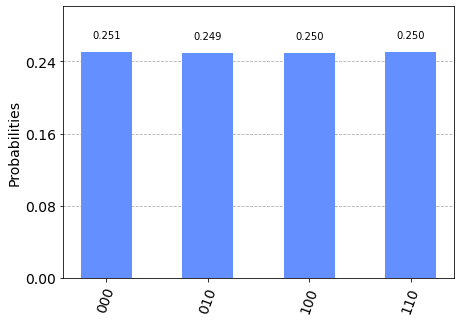

In [21]:
qc.append(qft_dagger(t),range(t)) # inverse quantum fourier transform only of the register (first 4 qubits)
qc.measure(range(t), range(t))
def run_circuit(qc):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qc, backend, shots = 100000).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

counts = run_circuit(qc)
print(counts)
plot_histogram(counts)

6. These results can now give us the phase estimations from their actual values and the next few cells will be to analyze these results so you can figure out the period. On a sidenote one can also see that since we have four equally possible results this would imply a period of four but for the sake of formality we must analyze this more.


In [22]:
rows, eigenvalues = [], []
for output in counts:
    decimal = int(output, 2)
    eigenvalue = decimal/(2**t)
    eigenvalues.append(eigenvalue)
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), "%i/%i = %.2f" % (decimal, 2**t, eigenvalue)])
print(tabulate(rows, headers=["Register Output", "Phase"]))

Register Output    Phase
-----------------  ----------
000(bin) = 0(dec)  0/8 = 0.00
100(bin) = 4(dec)  4/8 = 0.50
110(bin) = 6(dec)  6/8 = 0.75
010(bin) = 2(dec)  2/8 = 0.25


We can use built-in Python functionality `.as_integer_ratio()` to convert these phases to fractions:

In [11]:
0.333333333.as_integer_ratio()

(3002399748577931, 9007199254740992)

In [23]:
rows = []
for eigenvalue in eigenvalues:
    numerator, denominator = eigenvalue.as_integer_ratio()
    rows.append([eigenvalue, "%i/%i" % (numerator, denominator), denominator])
print(tabulate(rows, headers=["Phase", "Fraction", "Guess for r"], colalign=('right','right','right')))

  Phase    Fraction    Guess for r
-------  ----------  -------------
      0         0/1              1
    0.5         1/2              2
   0.75         3/4              4
   0.25         1/4              4


$2$ of our guesses for $r$ are $4$. This implies the period of function is $4$.